# LV Network Design Example 3

In [1]:
from python_electric.gui import ProjectModel
from python_electric.gui.build import build_network_topology

## Loading Network Topology

The network topology was configured using the GUI Builder. Here, the project file is loaded from disk and the network topology is built.

In [2]:
p = "./LV_design_03.pxe"
proj = ProjectModel.load(p)
topo = build_network_topology(proj)

> To use the GUI Builder, run script `main.py` in the `gui` sub-package.

## Check Cables

While building the network topology, python-electric also sizes the cables based on the loads that were assigned to the network connections when configuring the network. Here we check the results from the cable sizing routine.

In [3]:
from python_electric import Cable

def print_cable(cable: Cable):
    print(
        f"name: {cable.name}",
        f"------------------",
        f"load current (phase): {cable.I_b_ph.to('A'):~P.0f}",
        f"nominal current (phase): {cable.I_n_ph.to('A'):~P.0f}",
        f"actual ampacity (phase): {cable.I_z_ph.to('A'):~P.0f}",
        f"sizing based on In: {cable.sizing_based_on_I_n}",
        f"# conductors/phase: {cable.n_phase}",
        f"load current (conductor): {cable.I_b.to('A'):~P.0f}",
        f"nominal current (conductor): {cable.I_n.to('A'):~P.0f}",
        f"actual ampacity (conductor): {cable.I_z.to('A'):~P.0f}",
        f"stand. ampacity (conductor): {cable.I_z0.to('A'):~P.0f}",
        f"conductor csa: {cable.S.to('mm**2'):~P.0f}",
        sep="\n", end="\n\n"
    )


In [4]:
for cable in topo.iter_all_cables():
    print_cable(cable)

name: C1
------------------
load current (phase): 909 A
nominal current (phase): 1000 A
actual ampacity (phase): 964 A
sizing based on In: False
# conductors/phase: 3
load current (conductor): 303 A
nominal current (conductor): 320 A
actual ampacity (conductor): 321 A
stand. ampacity (conductor): 392 A
conductor csa: 185 mm²

name: C3
------------------
load current (phase): 526 A
nominal current (phase): 630 A
actual ampacity (phase): 690 A
sizing based on In: True
# conductors/phase: 2
load current (conductor): 263 A
nominal current (conductor): 320 A
actual ampacity (conductor): 345 A
stand. ampacity (conductor): 392 A
conductor csa: 185 mm²

name: C7
------------------
load current (phase): 238 A
nominal current (phase): 250 A
actual ampacity (phase): 258 A
sizing based on In: False
# conductors/phase: 1
load current (conductor): 238 A
nominal current (conductor): 250 A
actual ampacity (conductor): 258 A
stand. ampacity (conductor): 258 A
conductor csa: 95 mm²



## Voltage Drop

### Across Network Connections

In [5]:
for conn in topo.iter_all_connections():
    du, du_rel = topo.get_conn_voltage_drop(conn.name)
    print(f"voltage drop @ {conn.name}: {du:~P.2f}, {du_rel:~P.2f}")

voltage drop @ C0: 0.00 V, 0.00 %
voltage drop @ T1: 2.66 V, 1.15 %
voltage drop @ C1: 0.17 V, 0.08 %
voltage drop @ C3: 0.78 V, 0.34 %
voltage drop @ C7: 0.29 V, 0.12 %


### Voltage Drop Between Secondary Terminals of T1 and Load L7

In [6]:
du, du_rel = topo.get_bus_voltage_drop("L7", start_bus_id="T1")
print(f"voltage drop T1 - L7: {du:~P.2f}, {du_rel:~P.2f}")

voltage drop T1 - L7: 1.24 V, 0.54 %


## Short-Circuit Currents

In [7]:
from python_electric import ShortCircuitResult

def print_sc_result(bus_id: str, sc: ShortCircuitResult):
    print(
        f"bus: {bus_id}",
        f"-------------",
        f"MAX [{sc.fault_type_max}]: {sc.max.to('kA'):~P.0f}",
        f"MIN [{sc.fault_type_min}]: {sc.min.to('kA'):~P.0f}",
        sep="\n", end="\n\n"
    )


In [8]:
sc_results = topo.run_shortcircuit_calc()

for bus_id, sc in sc_results.items():
    print_sc_result(bus_id, sc)

bus: MV
-------------
MAX [ThreePhaseFault]: 14 kA
MIN [LineToGroundFault]: 9 kA

bus: T1
-------------
MAX [ThreePhaseFault]: 24 kA
MIN [LineToGroundFault]: 24 kA

bus: B1
-------------
MAX [ThreePhaseFault]: 23 kA
MIN [LineToGroundFault]: 23 kA

bus: B6
-------------
MAX [ThreePhaseFault]: 21 kA
MIN [LineToGroundFault]: 18 kA

bus: L7
-------------
MAX [ThreePhaseFault]: 20 kA
MIN [LineToGroundFault]: 16 kA



## Sizing PE-Conductors

In [9]:
print(topo.glob_pe_config)

cond_mat: copper
insul_mat: PVC
mech_protected: False
separated: True
t_interrupt: 200 ms


In [10]:
topo.size_all_pe_conductors()

for cable in topo.iter_all_cables():
    print(f"cable {cable.name}: S_pe = {cable.S_pe.to('mm**2'):~P.0f}")

cable C1: S_pe = 300 mm²
cable C3: S_pe = 185 mm²
cable C7: S_pe = 50 mm²


## Adding Circuit Breakers

### Cable C1

In [11]:
cb_C1_sug = topo.suggest_circuit_breaker("C1", safety_factor_Icu=1.1, prefer_adjustable=True)
print(cb_C1_sug)

standard: IEC 60947-2
category: adjustable
I_cu: 36 kA
k_m: 14.0


In [12]:
cb_C1 = topo.connect_circuit_breaker(
    "C1",
    standard=cb_C1_sug.standard,
    category=cb_C1_sug.category,
    I_cu=cb_C1_sug.I_cu,
    k_m=cb_C1_sug.k_m
)
print(cb_C1)

I_n     = 1000.0 A
I_r     = 909.3 A
I_nf    = 954.8 A
I_f     = 1182.1 A
t_conv  = 2.0 h
I_m_min = 10.2 kA
I_m_max = 15.3 kA
t_m     = 100.0 ms


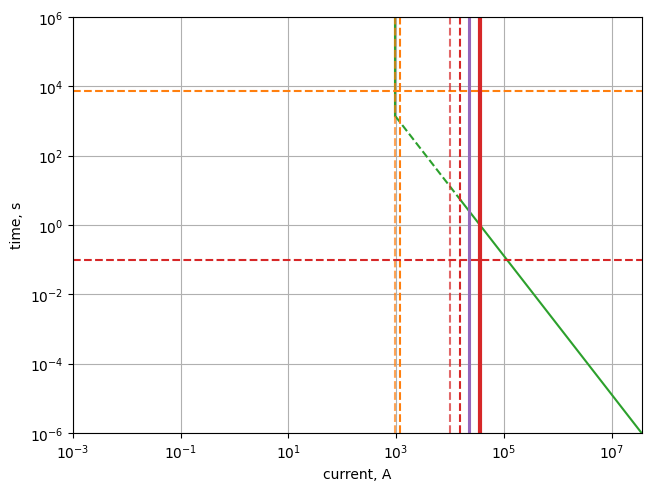

In [13]:
cb_C1_plot = topo.cable_plot("C1")
cb_C1_plot.show()

### Cable C3

In [14]:
cb_C3_sug = topo.suggest_circuit_breaker("C3", safety_factor_Icu=1.1, prefer_adjustable=True)
print(cb_C3_sug)

standard: IEC 60947-2
category: adjustable
I_cu: 36 kA
k_m: 14.0


In [15]:
cb_C3 = topo.connect_circuit_breaker(
    "C3",
    standard=cb_C3_sug.standard,
    category=cb_C3_sug.category,
    I_cu=cb_C3_sug.I_cu,
    k_m=cb_C3_sug.k_m
)
print(cb_C3)

I_n     = 630.0 A
I_r     = 526.4 A
I_nf    = 552.7 A
I_f     = 684.3 A
t_conv  = 2.0 h
I_m_min = 5.9 kA
I_m_max = 8.8 kA
t_m     = 100.0 ms


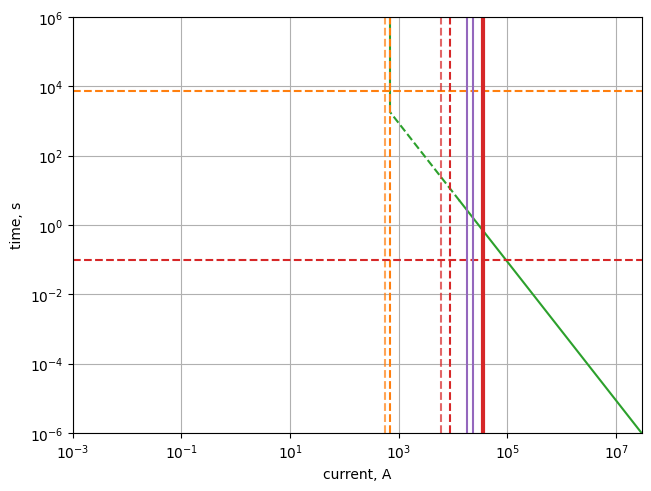

In [16]:
cb_C3_plot = topo.cable_plot("C3")
cb_C3_plot.show()

### Cable C7

In [17]:
cb_C7_sug = topo.suggest_circuit_breaker("C7", safety_factor_Icu=1.1, prefer_adjustable=True)
print(cb_C7_sug)

standard: IEC 60947-2
category: adjustable
I_cu: 25 kA
k_m: 14.0


In [18]:
cb_C7 = topo.connect_circuit_breaker(
    "C7",
    standard=cb_C7_sug.standard,
    category=cb_C7_sug.category,
    I_cu=cb_C7_sug.I_cu,
    k_m=cb_C7_sug.k_m
)
print(cb_C7)

I_n     = 250.0 A
I_r     = 237.7 A
I_nf    = 249.6 A
I_f     = 309.1 A
t_conv  = 2.0 h
I_m_min = 2.7 kA
I_m_max = 4.0 kA
t_m     = 100.0 ms


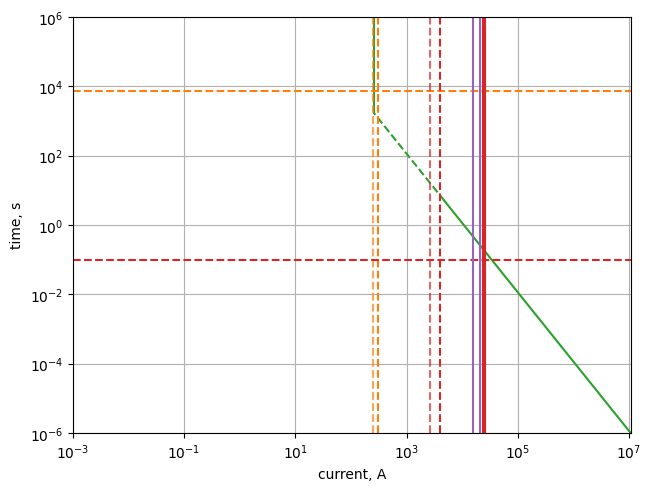

In [19]:
cb_C7_plot = topo.cable_plot("C7")
cb_C7_plot.show()

### Check Selectivity between CB7 and CB3

In [20]:
r = topo.check_selectivity(upcable_id="C3", downcable_id="C7")
print(r)

selectivity exists: True
total selectivity: True
maximum allowable tripping-time upstream circuit breaker: 180 ms
available margin for tripping-delay: 80 ms


### Check Selectivity between CB3 and CB1

In [21]:
r = topo.check_selectivity(upcable_id="C1", downcable_id="C3")
print(r)

selectivity exists: True
total selectivity: True
maximum allowable tripping-time upstream circuit breaker: 182 ms
available margin for tripping-delay: 82 ms


## Check Protection Against Indirect Contact at Load L7

### Final Circuit C7

In [22]:
r = topo.check_indirect_contact_protection(
    cable_id="C7",
    final_circuit=True,
    neutral_distributed=True
)
print(r)

passed: True
fault current: 54.4 kA
fault voltage: 121.0 V
max. allowable fault duration: 180 ms
max. allowable cable length: 68 m
max. allowable R of upstream PE-conductor(s): 30 mΩ


### Circuit C3

In [23]:
r = topo.check_indirect_contact_protection(
    cable_id="C3",
    final_circuit=False,
    neutral_distributed=True
)
print(r)

passed: True
fault current: 42.1 kA
fault voltage: 121.5 V
max. allowable fault duration: 180 ms
max. allowable cable length: 116 m
max. allowable R of upstream PE-conductor(s): 14 mΩ


## Check Earthing Resistance

In [24]:
import math
from python_electric import Q_
from python_electric.protection.earthing_system.TN import check_earthing_resistance

r = check_earthing_resistance(
    U_phase=topo.U_n / math.sqrt(3),
    R_e=Q_(30, 'ohm'),
    final_circuit=True
)
print(r)

passed: True
fault current: 6.6 A
fault voltage: 197.9 V
max. allowable fault duration: 75 ms
max. allowable earth-spreading R: 1 Ω
